## Setup dependencies

In [ ]:
try:
    import google.colab
    import subprocess
    import os.path
    p = subprocess.run(['git', 'rev-parse', '--is-inside-work-tree'], stdout=subprocess.PIPE, universal_newlines=True)
    if p.stdout == 'true\n':
        !git pull
    else:
        if not os.path.isdir('city_dsp_ap'):
            !git clone --depth 1 -q https://github.com/tweyde/city_dsp_ap.git
        %cd city_dsp_ap
except:
    %cd city_dsp_ap

/content/city_dsp_ap


In [ ]:
import numpy as np
from scipy import fft, signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
from IPython.display import Audio, display

## Controllable delay line

You will need to create a function that applies the desired effect to any input signal, where the effect can be dynamically modified by a control signal. The functions only need to be implemented for offline use, so you don't need to be handle input buffers of arbitrary sizes like in lab 6. It suffices to use a single for loop to run over all samples of the input and control signals, and create the output sample-by-sample.

In both cases, the control signal will be a sine of 2Hz. Create one of the required length yourself. Any signal should work as input signal. You can learn how to [upload your own files](https://colab.research.google.com/notebooks/io.ipynb) into Google Colab, but the easiest will be to use one of the wave files available in the `audio` directory. If you're loading a stereo file, it is allowed to mix it down into a single mono channel before passing it to the effect to simplify processing.

In [ ]:
%ls audio/*.wav

audio/20-16000HzExp5sec.wav  audio/carrier.wav*  audio/rockB.wav
audio/20-16000HzLin5sec.wav  audio/rockA.wav


#### UG
Program a controllable delay line. Mix the output with the original input to create a flanging effect. Use the control signal to vary the amount of delay between zero and a maximum value (1 millisecond would be a good default for this, use the samplerate to calculate how much samples this is).

Read in and play .wav audio files

In [ ]:
from scipy.io import wavfile

from dsp_ap.signals import AudioSignal, Spectrum
import pickle as pkl
from dataclasses import dataclass
from scipy import interpolate


In [ ]:

# File 1: exp5sec
exp5sec_samplerate, exp5sec_input_samples = wavfile.read('audio/20-16000HzExp5sec.wav')
exp5sec_input_samples = exp5sec_input_samples.T
exp5sec_num_channels = exp5sec_input_samples.shape[0] if exp5sec_input_samples.ndim > 1 else 1

# File 2: lin5sec
lin5sec_samplerate, lin5sec_input_samples = wavfile.read('audio/20-16000HzLin5sec.wav')
lin5sec_input_samples = lin5sec_input_samples.T
lin5sec_num_channels = lin5sec_input_samples.shape[0] if lin5sec_input_samples.ndim > 1 else 1

# File 3: carrier
carrier_samplerate, carrier_input_samples = wavfile.read('audio/carrier.wav')
carrier_input_samples = carrier_input_samples.T
carrier_num_channels = carrier_input_samples.shape[0] if carrier_input_samples.ndim > 1 else 1

# File 4: rockA
rockA_samplerate, rockA_input_samples = wavfile.read('audio/rockA.wav')
rockA_input_samples = rockA_input_samples.T
rockA_num_channels = rockA_input_samples.shape[0] if rockA_input_samples.ndim > 1 else 1

# File 5: rockB
rockB_samplerate, rockB_input_samples = wavfile.read('audio/rockB.wav')
rockB_input_samples = rockB_input_samples.T
rockB_num_channels = rockB_input_samples.shape[0] if rockB_input_samples.ndim > 1 else 1

print('Input - 20-16000HzExp5sec')
display(Audio(exp5sec_input_samples, rate=exp5sec_samplerate))
print('Input - 20-16000HzLin5sec')
display(Audio(lin5sec_input_samples, rate=lin5sec_samplerate))

print('Input - carrier')
display(Audio(carrier_input_samples, rate=carrier_samplerate))

print('Input - rockA')
display(Audio(rockA_input_samples, rate=rockA_samplerate))
print('Input - rockB')
display(Audio(rockB_input_samples, rate=rockB_samplerate))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(exp5sec_samplerate)
print(lin5sec_samplerate)
print(carrier_samplerate)
print(rockA_samplerate)
print(rockB_samplerate)

44100
44100
12000
44100
44100


In [ ]:
# Original Signals

# original_exp5sec_signal
original_exp5sec_signal = AudioSignal(exp5sec_input_samples, exp5sec_samplerate)
original_exp5sec_signal.play()
original_exp5sec_signal.display()

# original_lin5sec_signal
original_lin5sec_signal = AudioSignal(lin5sec_input_samples, lin5sec_samplerate)
original_lin5sec_signal.play()
original_lin5sec_signal.display()

# carrier_signal
carrier_signal = AudioSignal(carrier_input_samples, carrier_samplerate)
carrier_signal.play()
carrier_signal.display()

# rockA_signal
rockA_signal = AudioSignal(rockA_input_samples, rockA_samplerate)
rockA_signal.play()
#rockA_signal.display()

# rockB_signal
rockB_signal = AudioSignal(rockB_input_samples, rockB_samplerate)
rockB_signal.play()
#rockB_signal.display()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Control sine wave A - 5 sec - exp5, lin5

control_freq_a = 2
control_amp_a = 1
control_sample_rate_a = 44100
control_duration_a = 5

timepoints = np.arange(control_duration_a*control_sample_rate_a) / control_sample_rate_a
control_samples_a = control_amp_a * np.sin(2 * np.pi * control_freq_a * timepoints)
control_signal_a = AudioSignal(control_samples_a, control_sample_rate_a)

control_signal_a.play()
control_signal_a.display()

# Control sine wave B - 2 sec - carrier

control_freq_b = 2
control_amp_b = 1
control_sample_rate_b = 12000
control_duration_b = 2

timepoints = np.arange(control_duration_b*control_sample_rate_b) / control_sample_rate_b
control_samples_b = control_amp_b * np.sin(2 * np.pi * control_freq_b * timepoints)
control_signal_b = AudioSignal(control_samples_b, control_sample_rate_b)

control_signal_b.play()
control_signal_b.display()

# Control sine wave C - 12 sec - rockA, rockB

control_freq_c = 2
control_amp_c = 1
control_sample_rate_c = 44100
control_duration_c = 12

timepoints = np.arange(control_duration_c*control_sample_rate_c) / control_sample_rate_c
control_samples_c = control_amp_c * np.sin(2 * np.pi * control_freq_c * timepoints)
control_signal_c = AudioSignal(control_samples_c, control_sample_rate_c)

control_signal_c.play()
control_signal_c.display()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_filter(b, a, samplerate=None):
    w, h = signal.freqz(b, a)

    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')
    freqs = w / (2*np.pi)
    if samplerate:
        freqs *= samplerate
        ax1.set_xlabel('frequency [Hz]')
    else:
        ax1.set_xlabel('normalised frequency [cycles/sample]')

    ax1.plot(freqs, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('amplitude [dB]', color='b')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(freqs, angles, 'g')
    ax2.set_ylabel('angle [radians]', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()

def plot_spectrogram(time_signal, samplerate, title=''):
    frequencies, timepoints, specgram = signal.stft(time_signal, fs=samplerate, nperseg=1024)
    power_spectrogram = 20*np.log10(np.abs(specgram) +np.finfo(float).eps)

    fig = plt.figure()
    plt.pcolormesh(timepoints, frequencies, power_spectrogram, vmin=-99, vmax=0)
    plt.title(title)
    plt.ylabel('frequency [Hz]')
    plt.xlabel('time [s]')
    plt.xlim(0.5e7, 0.7e7)
    plt.xlim(5e7, 5.5e7)
    plt.ylim(0, 0.0005)
    plt.show()

In [ ]:
print('b1 - IIR Filter (Lowpass)')

# Lowpass filter for exp5sec and lin5sec
b1_a = signal.iirdesign(2000, 3000, 1, 80, ftype='butter', fs=control_sample_rate_a, output='sos')
plot_filter(*signal.sos2tf(b1_a), control_sample_rate_a)

# exp5sec
exp5sec_lowpass = signal.sosfilt(b1_a, exp5sec_input_samples)
plot_spectrogram(exp5sec_lowpass, control_sample_rate_a)
display(Audio(exp5sec_lowpass, rate=control_sample_rate_a))

# lin5sec
lin5sec_lowpass = signal.sosfilt(b1_a, lin5sec_input_samples)
plot_spectrogram(lin5sec_lowpass, control_sample_rate_a)
display(Audio(lin5sec_lowpass, rate=control_sample_rate_a))

# Lowpass filter for carrier
b1_b = signal.iirdesign(2000, 3000, 1, 80, ftype='butter', fs=control_sample_rate_b, output='sos')
plot_filter(*signal.sos2tf(b1_b), control_sample_rate_b)

carrier_lowpass = signal.sosfilt(b1_b, carrier_input_samples)
plot_spectrogram(carrier_lowpass, control_sample_rate_b)
display(Audio(carrier_lowpass, rate=control_sample_rate_b))

# Lowpass filter for rockA and rockB
b1_c = signal.iirdesign(2000, 3000, 1, 80, ftype='butter', fs=control_sample_rate_c, output='sos')
plot_filter(*signal.sos2tf(b1_c), control_sample_rate_c)

# rockA
rockA_lowpass = signal.sosfilt(b1_c, rockA_input_samples)
#plot_spectrogram(rockA_lowpass, control_sample_rate_c)
display(Audio(rockA_lowpass, rate=control_sample_rate_c))

# rockB
rockB_lowpass = signal.sosfilt(b1_c, rockB_input_samples)
#plot_spectrogram(rockB_lowpass, control_sample_rate_c)
display(Audio(rockB_lowpass, rate=control_sample_rate_c))


# High pass filters

print('b2 - IIR Filter (Highpass)')

# Highpass filter for exp5sec and lin5sec
b2_a = signal.iirdesign(3000, 2000, 1, 80, ftype='butter', fs=control_sample_rate_a, output='sos')
plot_filter(*signal.sos2tf(b2_a), control_sample_rate_a)

# exp5sec
exp5sec_highpass = signal.sosfilt(b2_a, exp5sec_input_samples)
plot_spectrogram(exp5sec_highpass, control_sample_rate_a)
display(Audio(exp5sec_highpass, rate=control_sample_rate_a))

# lin5sec
lin5sec_highpass = signal.sosfilt(b2_a, lin5sec_input_samples)
plot_spectrogram(lin5sec_highpass, control_sample_rate_a)
display(Audio(lin5sec_highpass, rate=control_sample_rate_a))

# Highpass filter for carrier
b2_b = signal.iirdesign(3000, 2000, 1, 80, ftype='butter', fs=control_sample_rate_b, output='sos')
plot_filter(*signal.sos2tf(b2_b), control_sample_rate_b)

carrier_highpass = signal.sosfilt(b2_b, carrier_input_samples)
plot_spectrogram(carrier_highpass, control_sample_rate_b)
display(Audio(carrier_highpass, rate=control_sample_rate_b))

# Highpass filter for rockA and rockB
b2_c = signal.iirdesign(3000, 2000, 1, 80, ftype='butter', fs=control_sample_rate_c, output='sos')
plot_filter(*signal.sos2tf(b2_c), control_sample_rate_c)

rockA_highpass = signal.sosfilt(b2_c, rockA_input_samples)
#plot_spectrogram(rockA_highpass, control_sample_rate_c)
display(Audio(rockA_highpass, rate=control_sample_rate_c))

rockB_highpass = signal.sosfilt(b2_c, rockB_input_samples)
#plot_spectrogram(rockB_highpass, control_sample_rate_c)
display(Audio(rockB_highpass, rate=control_sample_rate_c))

Output hidden; open in https://colab.research.google.com to view.

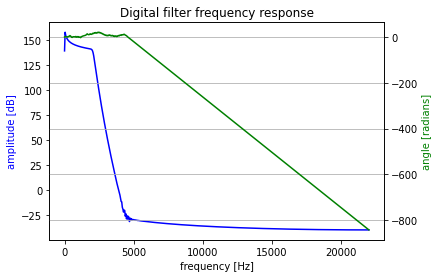

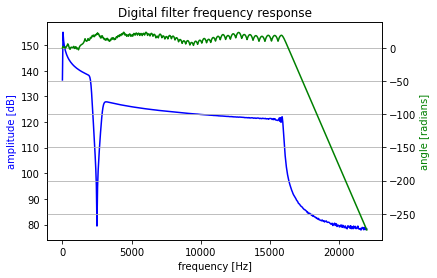

KeyboardInterrupt: ignored

In [23]:
# exp5sec

# Looping through signal, processing at regular intervals
i = 0
j = 0
for samp in range(len(exp5sec_input_samples)):
    
    if i % 1000 == 0:
      # get a single control value, 'cv',  from sine wave
      cv = control_samples_a[samp]

      # create new filter coefficients b_comb by interpolating between b1 and b2, using cv as interpolation factor
      b_comb = (1-cv) * exp5sec_lowpass + cv * exp5sec_highpass

      # Convolve signal with b_comb
      filtered_samples = signal.lfilter(b_comb, 1, exp5sec_input_samples)
      if j < 3:
        plot_filter(b_comb, 1, exp5sec_samplerate)
        display(Audio(filtered_samples, rate=exp5sec_samplerate))

      # append to output signal
      exp5sec_output_samples = exp5sec_input_samples * filtered_samples
      
    
    i = i + 1

display(Audio(exp5sec_output_samples, rate=exp5sec_samplerate))

In [ ]:
# lin5sec

# Looping through signal, processing at regular intervals
i = 0
for samp in range(len(lin5sec_input_samples)):
    
    if i % 1000 == 0:
      # get a single control value, 'cv',  from sine wave
      cv = control_samples_a[samp]

      # create new filter coefficients b_comb by interpolating between b1 and b2, using cv as interpolation factor
      b_comb = (1-cv) * lin5sec_lowpass + cv * lin5sec_highpass

      # Convolve signal with b_comb
      filtered_samples = signal.lfilter(b_comb, 1, lin5sec_input_samples)
      plot_filter(b_comb, 1, lin5sec_samplerate)
      display(Audio(filtered_samples, rate=lin5sec_samplerate))

      # append to output signal
      lin5sec_output_samples = lin5sec_input_samples * filtered_samples
      
    
    i = i + 1

display(Audio(lin5sec_output_samples, rate=lin5sec_samplerate))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# carrier

# Looping through signal, processing at regular intervals
i = 0
for samp in range(len(carrier_input_samples)):
    
    if i % 1000 == 0:
      # get a single control value, 'cv',  from sine wave
      cv = control_samples_b[samp]

      # create new filter coefficients b_comb by interpolating between b1 and b2, using cv as interpolation factor
      b_comb = (1-cv) * carrier_lowpass + cv * carrier_highpass

      # Convolve signal with b_comb
      filtered_samples = signal.lfilter(b_comb, 1, carrier_input_samples)
      plot_filter(b_comb, 1, carrier_samplerate)
      display(Audio(filtered_samples, rate=carrier_samplerate))

      # append to output signal
      carrier_output_samples = carrier_input_samples * filtered_samples
      
    
    i = i + 1

display(Audio(carrier_output_samples, rate=carrier_samplerate))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# rockA

# Looping through signal, processing at regular intervals
i = 0
for samp in range(len(rockA_input_samples)):
    
    if i % 1000 == 0:
      # get a single control value, 'cv',  from sine wave
      cv = control_samples_c[samp]

      # create new filter coefficients b_comb by interpolating between b1 and b2, using cv as interpolation factor
      b_comb = (1-cv) * rockA_lowpass + cv * rockA_highpass

      # Convolve signal with b_comb
      filtered_samples = signal.lfilter(b_comb, 1, rockA_input_samples)
      plot_filter(b_comb, 1, rockA_samplerate)
      display(Audio(filtered_samples, rate=rockA_samplerate))

      # append to output signal
      rockA_output_samples = rockA_input_samples * filtered_samples
      
    
    i = i + 1

display(Audio(rockA_output_samples, rate=rockA_samplerate))

In [ ]:
# rockB

# Looping through signal, processing at regular intervals
i = 0
for samp in range(len(rockB_input_samples)):
    
    if i % 1000 == 0:
      # get a single control value, 'cv',  from sine wave
      cv = control_samples_c[samp]

      # create new filter coefficients b_comb by interpolating between b1 and b2, using cv as interpolation factor
      b_comb = (1-cv) * rockB_lowpass + cv * rockB_highpass

      # Convolve signal with b_comb
      filtered_samples = signal.lfilter(b_comb, 1, rockB_input_samples)
      plot_filter(b_comb, 1, rockB_samplerate)
      display(Audio(filtered_samples, rate=rockB_samplerate))

      # append to output signal
      rockB_output_samples = rockB_input_samples * filtered_samples
      
    
    i = i + 1

display(Audio(rockB_output_samples, rate=rockB_samplerate))

## Time series prediction with financial data

In this part, you're going to use long term US stock market data (monthly indices, dividends, earnings, etc. since 1871). Information about the data provenance and references can be found at http://www.econ.yale.edu/~shiller/data.htm (especially the 2nd paragraph). The data is available in the file `data/financial_data.csv`.

It is stored as comma-separated numerical values, with a header containing column names. Therefore we can use [`np.genfromtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) to read it.

In [ ]:
financial = np.genfromtxt('data/financial_data.csv', delimiter=',', skip_header=2, names=True)

The result is a structured array, which means that we can access each of the columns in the table by its name. The list of all colums can be found below.

In [ ]:
financial.dtype.names

('Date',
 'SP_Comp_P',
 'Dividend_D',
 'Earnings_E',
 'Consumer_Price_Index_CPI',
 'Date_Fraction',
 'Long_Interest_Rate_GS10',
 'Real_Price',
 'Real_Dividend',
 'Real_Earnings',
 'Cyclically_Adjusted_Price_Earnings_Ratio_PE10_or_CAPE')

You can access the columns using their names between square brackets, like you would for a dictionary. It's advised to store the columns you need in helper variables, to avoid long statements resulting from the long column names.

In [ ]:
date = financial['Date']
real_price = financial['Real_Price']

Now you can easily use the data, for instance to plot it.

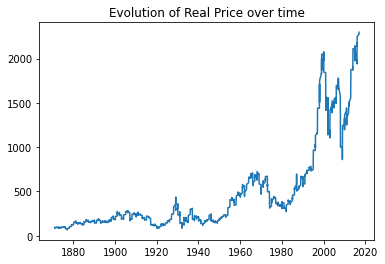

In [ ]:
plt.figure()
plt.plot(date, real_price)
plt.title('Evolution of Real Price over time')
plt.show()

Using this data, your task is to:

1. Look for long term trends on a linear and log scale and de-trend the data first.
2. Calculate the FFT of the signal of interest, to estimate possible periodicities. You can use a window to avoid spectral leaking.
3. Refine your analysis by adjusting the size of the dataset (e.g. if you model annual patterns, make sure your dataset size is a multiple of 12).

In [ ]:
from scipy import signal, fft

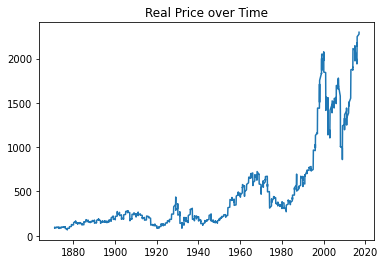

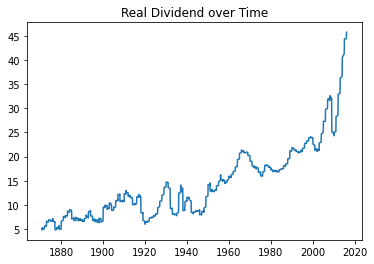

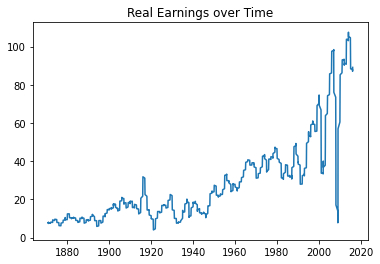

In [ ]:
# Time Series Prediction with Financial Data

# Viewing Data with time

# Real price
plt.figure()
plt.plot(financial['Date'], financial['Real_Price'])
plt.title('Real Price over Time')
plt.show()

# Real Dividend
plt.figure()
plt.plot(financial['Date'], financial['Real_Dividend'])
plt.title('Real Dividend over Time')
plt.show()

# Real Earnings
plt.figure()
plt.plot(financial['Date'], financial['Real_Earnings'])
plt.title('Real Earnings over Time')
plt.show()


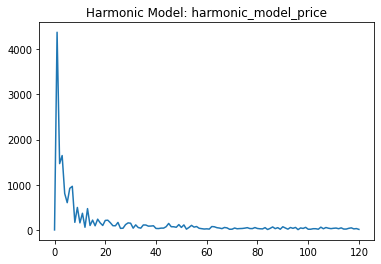

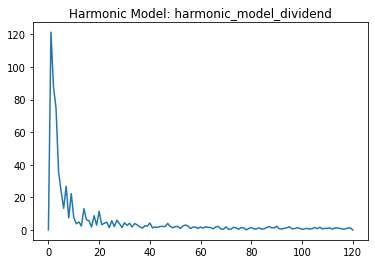

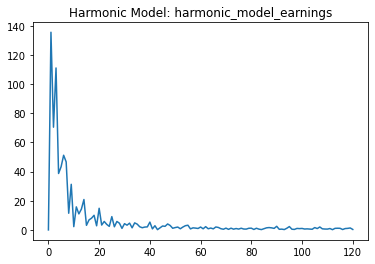

In [ ]:
# Select a periodic excerpt of data - 20 years
excerpt_length = 12 * 20
excerpt_price = financial['Real_Price'][:excerpt_length]
excerpt_dividend = financial['Real_Dividend'][:excerpt_length]
excerpt_earnings = financial['Real_Earnings'][:excerpt_length]

# Remove the mean
avg_price = np.mean(excerpt_price)
norm_excerpt_price = excerpt_price - avg_price

avg_dividend = np.mean(excerpt_dividend)
norm_excerpt_dividend = excerpt_dividend - avg_dividend

avg_earnings = np.mean(excerpt_earnings)
norm_excerpt_earnings = excerpt_earnings - avg_earnings

# Calculate Fourier coefficients
harmonic_model_price = fft.rfft(norm_excerpt_price)
harmonic_model_dividend = fft.rfft(norm_excerpt_dividend)
harmonic_model_earnings = fft.rfft(norm_excerpt_earnings)

# Show harmonic models
plt.figure()
plt.plot(np.abs(harmonic_model_price))
plt.title('Harmonic Model: harmonic_model_price')
plt.show()

plt.figure()
plt.plot(np.abs(harmonic_model_dividend))
plt.title('Harmonic Model: harmonic_model_dividend')
plt.show()

plt.figure()
plt.plot(np.abs(harmonic_model_earnings))
plt.title('Harmonic Model: harmonic_model_earnings')
plt.show()

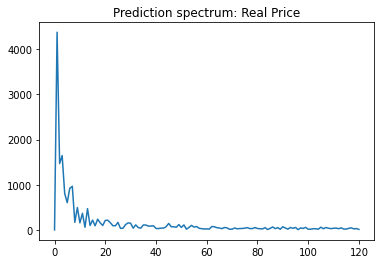

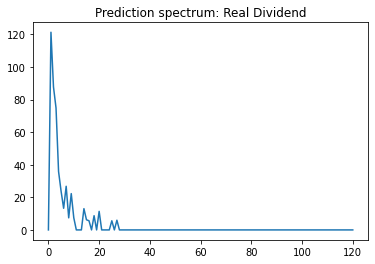

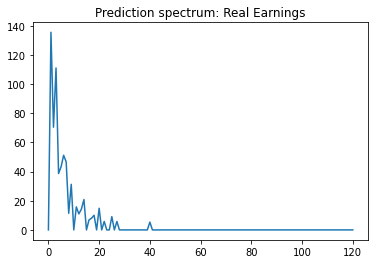

In [ ]:
# Predictions

threshold = 5

predict_spectrum_price = np.where(np.abs(harmonic_model_price) < threshold, 0, harmonic_model_price)
predict_spectrum_dividend = np.where(np.abs(harmonic_model_dividend) < threshold, 0, harmonic_model_dividend)
predict_spectrum_earnings = np.where(np.abs(harmonic_model_earnings) < threshold, 0, harmonic_model_earnings)

plt.figure()
plt.plot(np.abs(predict_spectrum_price))
plt.title('Prediction spectrum: Real Price')
plt.show()
prediction_price = fft.irfft(predict_spectrum_price)

plt.figure()
plt.plot(np.abs(predict_spectrum_dividend))
plt.title('Prediction spectrum: Real Dividend')
plt.show()
prediction_dividend = fft.irfft(predict_spectrum_dividend)

plt.figure()
plt.plot(np.abs(predict_spectrum_earnings))
plt.title('Prediction spectrum: Real Earnings')
plt.show()
prediction_earnings = fft.irfft(predict_spectrum_earnings)

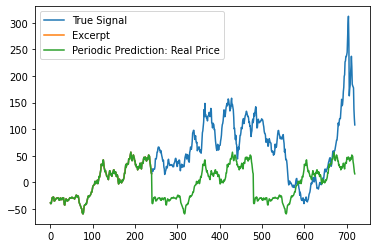

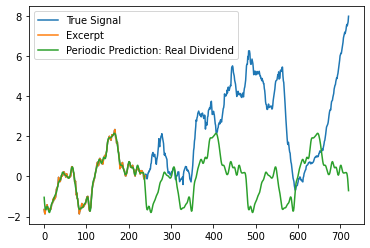

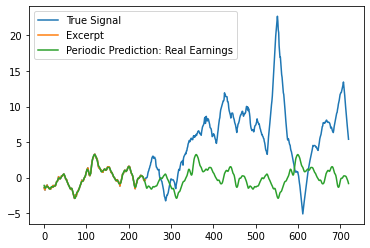

In [ ]:
# Comparing true signals to predictions

test_length = 2
total_length = (test_length + 1) * excerpt_length

true_signal_price = financial['Real_Price'][:total_length] - avg_price
periodic_prediction_price = np.tile(prediction_price, test_length+1)

true_signal_dividend = financial['Real_Dividend'][:total_length] - avg_dividend
periodic_prediction_dividend = np.tile(prediction_dividend, test_length+1)

true_signal_earnings = financial['Real_Earnings'][:total_length] - avg_earnings
periodic_prediction_earnings = np.tile(prediction_earnings, test_length+1)

plt.figure()
plt.plot(true_signal_price, label = 'True Signal')
plt.plot(norm_excerpt_price, label='Excerpt')
plt.plot(periodic_prediction_price, label='Periodic Prediction: Real Price')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(true_signal_dividend, label='True Signal')
plt.plot(norm_excerpt_dividend, label='Excerpt')
plt.plot(periodic_prediction_dividend, label='Periodic Prediction: Real Dividend')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(true_signal_earnings, label='True Signal')
plt.plot(norm_excerpt_earnings, label='Excerpt')
plt.plot(periodic_prediction_earnings, label='Periodic Prediction: Real Earnings')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Calc prediction error

rmse_price = np.sqrt(np.mean(np.power(true_signal_price[excerpt_length:] - periodic_prediction_price[excerpt_length:], 2)))
rmse_dividend = np.sqrt(np.mean(np.power(true_signal_dividend[excerpt_length:] - periodic_prediction_dividend[excerpt_length:], 2)))
rmse_earnings = np.sqrt(np.mean(np.power(true_signal_earnings[excerpt_length:] - periodic_prediction_earnings[excerpt_length:], 2)))

print(rmse_price)
print(rmse_dividend)
print(rmse_earnings)

90.17101414927266
3.5446960174828015
7.825476416408929
